In [1]:
dataset_name = "ibm-common-stock-closing-prices"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path,header=0)
data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")

data["timestamp"] = data["Date"]
del data["Date"]
data["value"] = data["IBM common stock closing prices"]
del data["IBM common stock closing prices"]

start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

missing = adclasses.find_missing_time_steps(start_date, end_date, '1D', data)
print("Missing time steps: ", missing)

data = adclasses.fill_missing_time_steps(start_date, end_date, '1D', data, method="linear")

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1D", dateformat="%Y-%m-%d", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())

true_outlier_dates = ["1965-06-08 00:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)


Start date:  1962-01-02T00:00:00.000000000
End date:  1965-12-31T00:00:00.000000000
Missing time steps:  DatetimeIndex(['1962-01-06', '1962-01-07', '1962-01-13', '1962-01-14',
               '1962-01-20', '1962-01-21', '1962-01-27', '1962-01-28',
               '1962-02-03', '1962-02-04',
               ...
               '1965-11-28', '1965-12-04', '1965-12-05', '1965-12-11',
               '1965-12-12', '1965-12-18', '1965-12-19', '1965-12-24',
               '1965-12-25', '1965-12-26'],
              dtype='datetime64[ns]', length=452, freq=None)
Length:  1460
Time step size:  1D
Start Date:  1962-01-02T00:00:00.000000000
End Date:  1965-12-31T00:00:00.000000000
Date Format:  %Y-%m-%d
True outlier indices:  [1253]


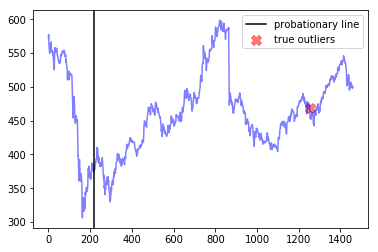

In [4]:
ad.plot_outliers([], true_outlier_indices)

# SARIMA: using own params

# trend but no seasonality -> try brown exponential smoothing

Final parameters:  (0, 2, 2, 0, 0, 0, 0)


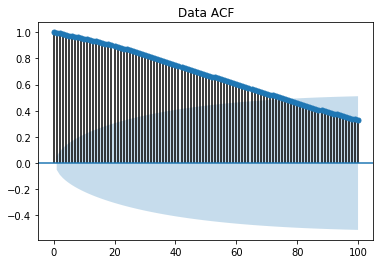

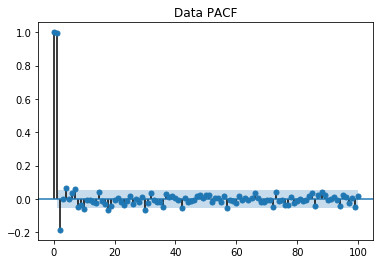

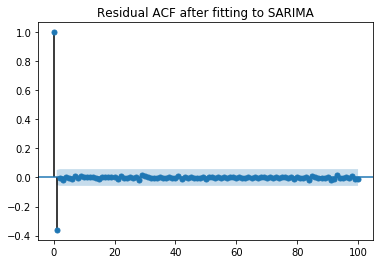

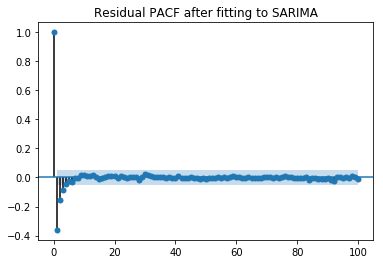

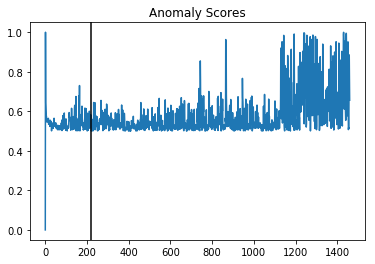

Time:  1.0190792083740234
RMSE:  17.275708537470535


['anomaly_scores/SARIMA_guide/ibm-common-stock-closing-prices']

In [5]:
save_path = "anomaly_scores/SARIMA_guide/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,p=0, d=2, q=2, big_p=0, big_d=0, big_q=0, s=0, plot_anomaly_score=True, plot_acf=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1434.946, BIC=1455.253, Fit time=0.153 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1440.779, BIC=1447.548, Fit time=0.087 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1430.384, BIC=1440.538, Fit time=0.173 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1431.550, BIC=1441.704, Fit time=0.136 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1432.382, BIC=1445.920, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1432.384, BIC=1445.922, Fit time=0.153 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.927 seconds
Final parameters:  (1, 1, 0, 0, 0, 0, 0)


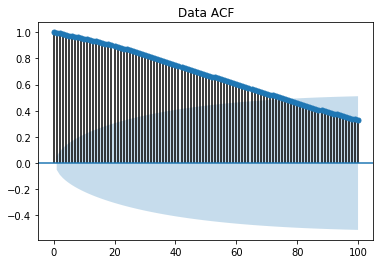

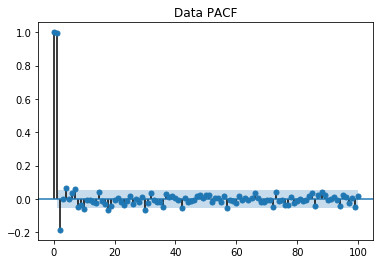

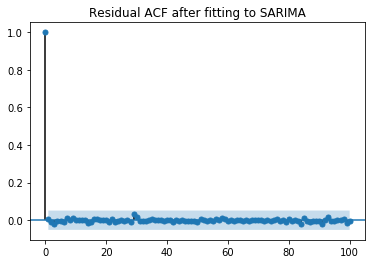

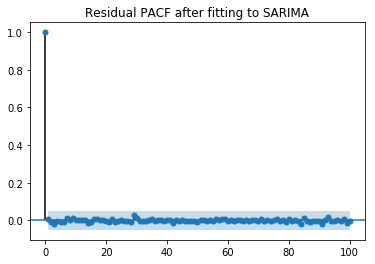

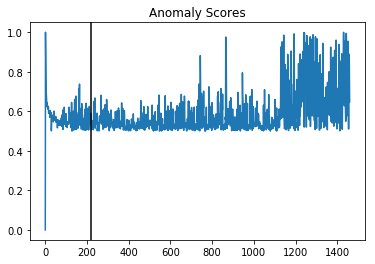

Time:  1.3860211372375488
RMSE:  15.625842442973696


['anomaly_scores/SARIMA_auto/ibm-common-stock-closing-prices']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,autoarima=True, autoarima_season=False, plot_acf=True, maxiter=3, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


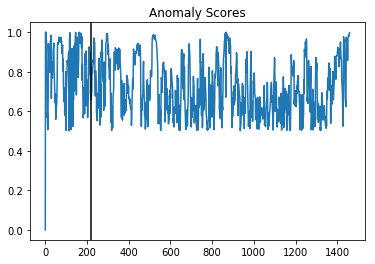

Time:  15.991342067718506
RMSE:  14.36455271408514


['anomaly_scores/Prophet/ibm-common-stock-closing-prices']

In [7]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

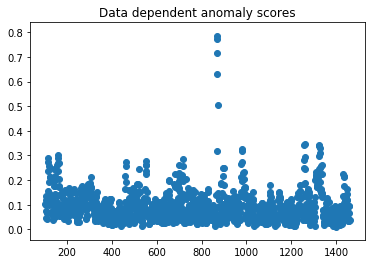

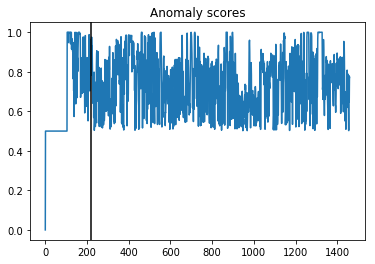

Time:  91.25074577331543


['anomaly_scores/RNN/ibm-common-stock-closing-prices']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

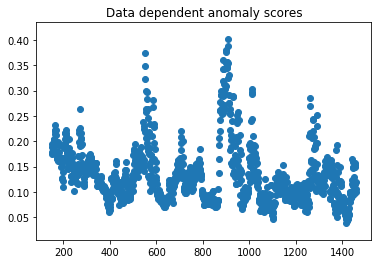

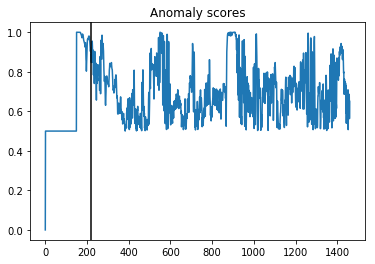

Time:  110.67638349533081


['anomaly_scores/RNN/ibm-common-stock-closing-prices']

In [8]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

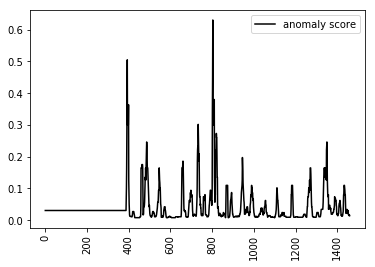

Time:  14.35


['anomaly_scores/HTM/ibm-common-stock-closing-prices']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 14.35)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 14.35}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (40,030 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (60,)           60
donut/p_x_given_z/x_mean/kernel  (100, 60)    6,000
donut/p_x_given_z/x_std/bias     (60,)           60
donut/p_x_given_z/x_std/kernel   (100, 60)    6,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (60, 100)    6,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 0, ETA 0.3497s] Learning rate decreased to 

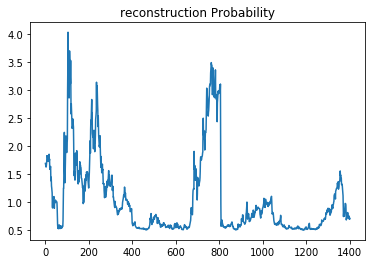

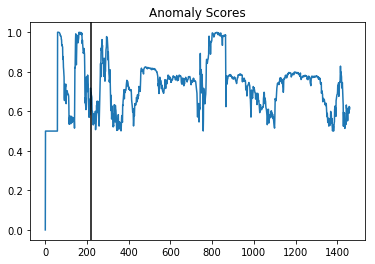

Time:  7.332625389099121


['anomaly_scores/Donut/ibm-common-stock-closing-prices']

In [10]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,window_size=60, plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

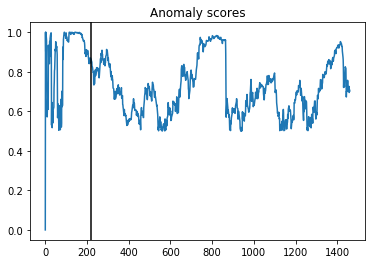

Time:  0.29846620559692383


['anomaly_scores/windowed_gaussian/ibm-common-stock-closing-prices']

In [12]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

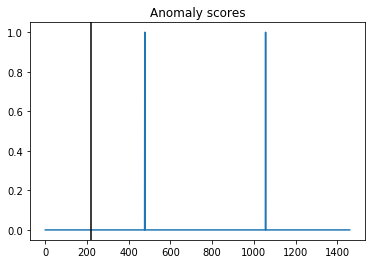

Time:  7.977140188217163


['anomaly_scores/hotsax/ibm-common-stock-closing-prices']

In [13]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [14]:
# no twitter bc no seasonality
# no stl bc no seasonality